# NE 204 Lab 1 Analysis
## Kalie Knecht
Lab Partners: Ian Kolaja, Trevor Arino, and <s>Karishma Shah</s>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg

import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.integrate as integrate
from scipy.optimize import curve_fit
import scipy.signal
from bokeh.io import show, output_file
from bokeh.plotting import figure
from bokeh.models import HoverTool
import time
import pandas as pd

# import tool repo
import sys

sys.path.append('/Users/kalie/courses/ne204/lab/lab_partners/ne204lib')
from kit204lib.spectrum import Spectrum
from kit204lib.filters import trapezoidal_filter
from kit204lib.analyze_waveform import plot_pulses, fit_tau
from kit204lib.make_histogram import make_histogram

## import data

In [2]:
print('calibration')
f_name = 'data/calibration.h5'
f_data = h5py.File(f_name,'r')
calibration = f_data['raw_data'][()]
calibration_events = f_data['event_data'][()]
print(str(calibration.shape[0])+' events')

print('co + cs calibration')
f_name = 'data/cocs_calibration.h5'
f_data = h5py.File(f_name,'r')
co_cs = f_data['raw_data'][()]
co_cs_events = f_data['event_data'][()]
print(str(co_cs.shape[0])+' events')

print('ba calibration')
f_name = 'data/ba_calibration.h5'
f_data = h5py.File(f_name,'r')
ba = f_data['raw_data'][()]
ba_events = f_data['event_data'][()]
print(str(ba.shape[0])+' events')

calibration
914193 events
co + cs calibration
228751 events
ba calibration
85135 events


## Calibration source information
* Cs-137
    * 10.2 $\mu$Ci, 377.4 kBq, 1-Jun-13
    * half life: 30.08(9) y (NNDC)
    * source strength on 10/14/22: 8.22 $\mu$Ci
    * source strength on 10/21/22: 8.21 $\mu$Ci
    * Associated gamma-ray energy:
        * 662 keV, 85.10(20) %
* Co-60 
    * Source 1 (plastic)
        * 9.947 $\mu$Ci, 368.0 kBq, 15-Mar-12
        * source strength on 10/14: 2.47 $\mu$Ci
        * source strength on 10/21: 2.47 $\mu$Ci
    * Source 2 (foil window)
        * 9.384 $\mu$Ci, 347.2 kBq, 15-Jan-08
        * source strength on 10/14: 1.35 $\mu$Ci
        * source strength on 10/21: N/A
    * Half life: 1925.28(14) d (NNDC) 
    * Associated gamma-ray energies (NNDC):
        * 1173.228(3) keV, 99.85(3)%
        * 1332.492(4) keV, 99.9826(20)%
* Ba-133 
    * Source 1 (plastic)
        * 10.57 $\mu$Ci, 391.1 kBq, 15-Mar-12
        * source strengh on 10/14: 5.27 $\mu$Ci
        * source strength on 10/21: 5.27 $\mu$Ci
    * Source 2 (foil window)
        * 9.984 $\mu$Ci, 369.4 kBq, 15-Oct-20
        * source strength on 10/14: 8.75 $\mu$Ci
        * source strength on 10/21: N/A
    * Half life: 10.551(11) y (NNDC)
    * Associated gamma-ray energy (NNDC):
        * 356.0129(7) keV, 62.05%
<img src="figs/IMG_9241.jpg" alt="sources" width="300"/>

In [3]:
def find_activity(t12,A0,time_elapsed):
    decay_constant = np.log(2)/t12
    return A0 * np.exp(-decay_constant*time_elapsed)
    
print('Cs137')
Acs1014 = find_activity(30.09,10.2,9 + 4/12 + 13/365.25)
Acs1021 = find_activity(30.09,10.2,9 + 4/12 + 20/365.25)
print('10/14: ',Acs1014)
print('10/21: ',Acs1021)
print('----------------------------')
print('Co60 (source 1)')
Aco1014_1 = find_activity(1925.28,9.947,10*365.25+7*30.5)
Aco1021_1 = find_activity(1925.28,9.947,10*365.25+7*30.5+7)
print('10/14: ',Aco1014_1)
print('10/21: ',Aco1021_1)
print('Co60 (source 2)')
Aco1014_2 = find_activity(1925.28,9.384,14*365.25+9*30.5+6)
print('10/14: ',Aco1014_2)
print('----------------------------')
print('Ba133 (source 1)')
Aba1014_1 = find_activity(10.551,10.57,10+7/12)
Aba1021_1 = find_activity(10.551,10.57,10+7/12 + 6/365.25)
print('10/14: ',Aba1014_1)
print('10/21: ',Aba1021_1)
print('Ba133 (source 2)')
Aba1014_2 = find_activity(10.551,9.984,2)
print('10/14: ',Aba1014_2)

Cs137
10/14:  8.219973963552464
10/21:  8.216345809926503
----------------------------
Co60 (source 1)
10/14:  2.472965072972052
10/21:  2.4667406305836295
Co60 (source 2)
10/14:  1.3458639761919022
----------------------------
Ba133 (source 1)
10/14:  5.273785855689279
10/21:  5.268097574777805
Ba133 (source 2)
10/14:  8.75472851860254


# Clean data
The event data timestamps show that the last several waveforms are repeated. This is a result of the data aquisition software - it seems that the buffer dumps the last data it collected at the end of the measurement. This represents a relatively small fraction of the data. To analyze the data, these repeated events must first be removed.

<IPython.core.display.Javascript object>


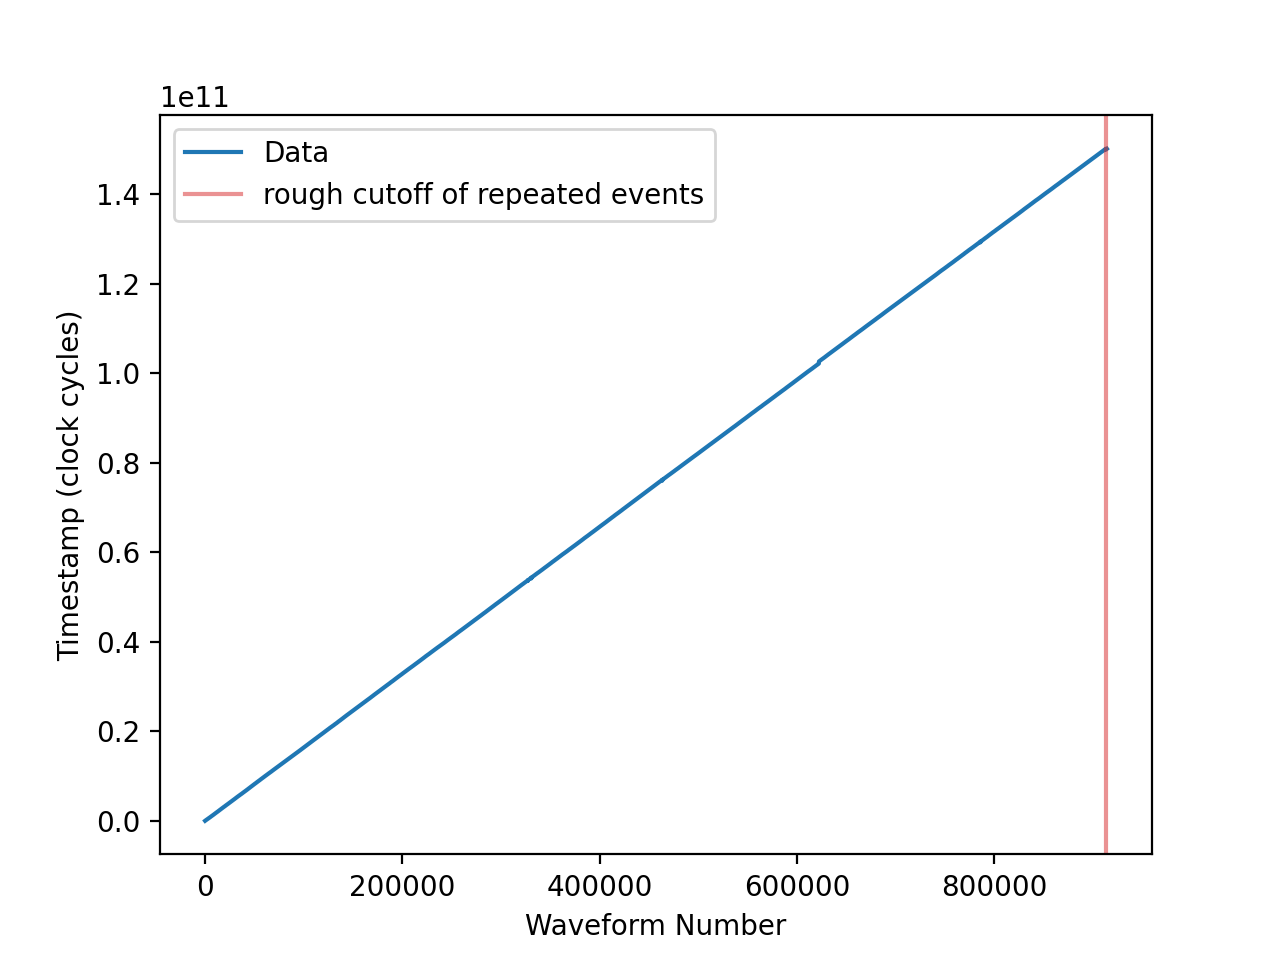

In [3]:
plt.figure()
plt.plot(calibration_events['timestamp'],label='Data')
plt.axvline(913017,c='tab:red',alpha=.5,label='rough cutoff of repeated events')
plt.legend()
plt.xlabel('Waveform Number')
plt.ylabel('Timestamp (clock cycles)')
plt.show()

<IPython.core.display.Javascript object>


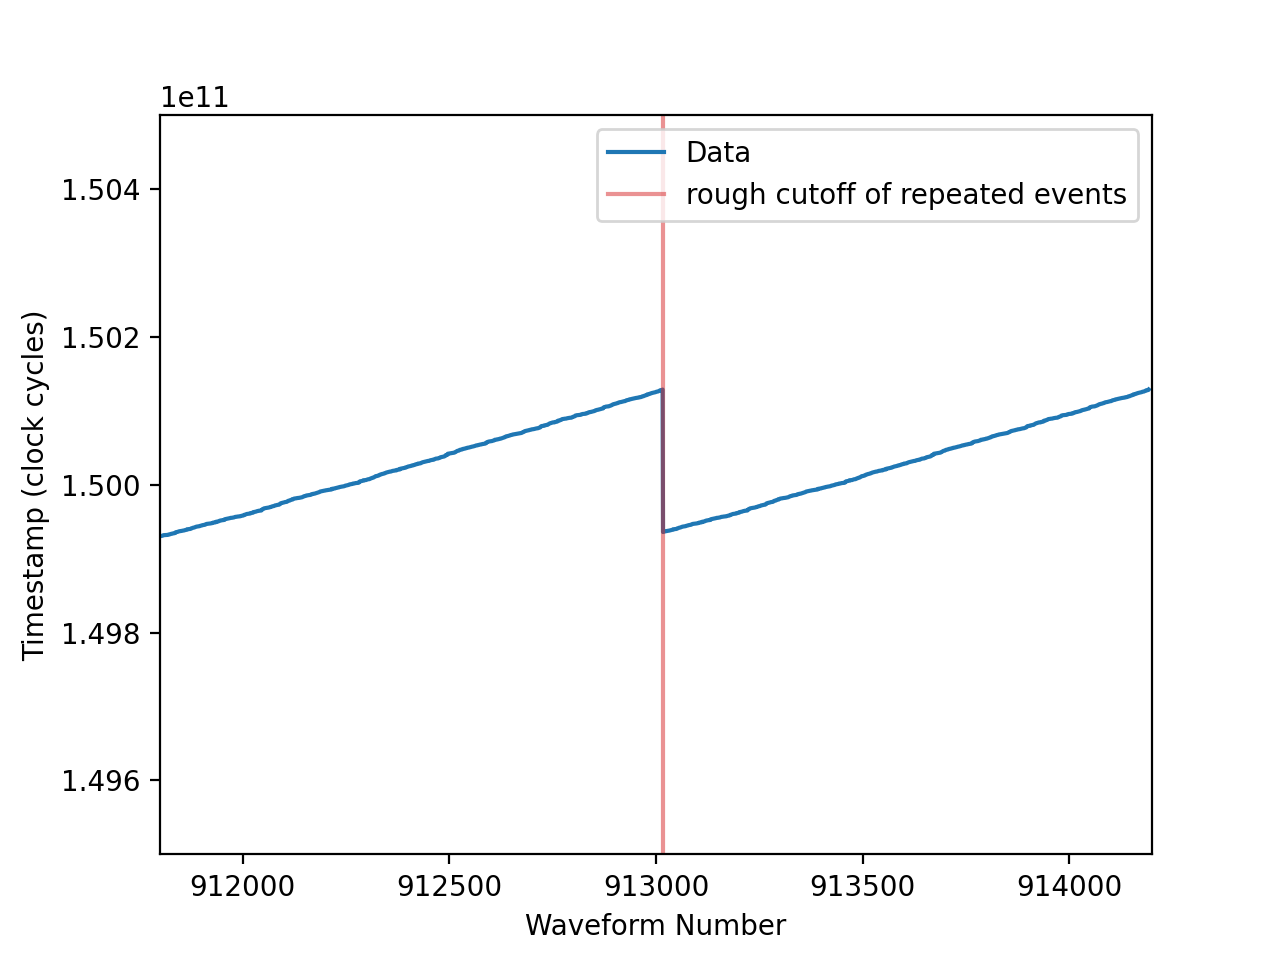

In [4]:
plt.figure()
plt.plot(calibration_events['timestamp'],label='Data')
plt.axvline(913017,c='tab:red',alpha=.5,label='rough cutoff of repeated events')
plt.legend()
plt.xlim(911800,914200)
plt.ylim(1.495e11,1.505e11)
plt.xlabel('Waveform Number')
plt.ylabel('Timestamp (clock cycles)')
plt.show()

In [21]:
# find unique waveforms
unique_waves, index, counts = np.unique(calibration_events['timestamp'],return_index=True,return_counts=True)
calibration_events_cleaned = calibration_events[index]
calibration_cleaned = np.int16(calibration[index])

# also clean other data
unique_waves, index, counts = np.unique(co_cs_events['timestamp'],return_index=True,return_counts=True)
co_cs_events_cleaned = co_cs_events[index]
co_cs_cleaned = np.int16(co_cs[index])

unique_waves, index, counts = np.unique(ba_events['timestamp'],return_index=True,return_counts=True)
ba_events_cleaned = ba_events[index]
ba_cleaned = np.int16(ba[index])

In [7]:
repeated_indices = index[counts == 2]
unique_repeated_events = calibration_events[repeated_indices]
print('total events repeated',len(unique_repeated_events))
repeated_events = calibration_events[np.isin(calibration_events['timestamp'],unique_repeated_events['timestamp'])]
repeated_data = calibration[np.isin(calibration_events['timestamp'],unique_repeated_events['timestamp'])]
print('total events repeated',len(repeated_events))
len(unique_repeated_events) * 2 == len(repeated_events)

total events repeated 172
total events repeated 172


False

In [8]:
# split data in half - first occurence and second occurance
pulses1 = repeated_data[:6632] 
pulses2 = repeated_data[-6632:] 

<IPython.core.display.Javascript object>


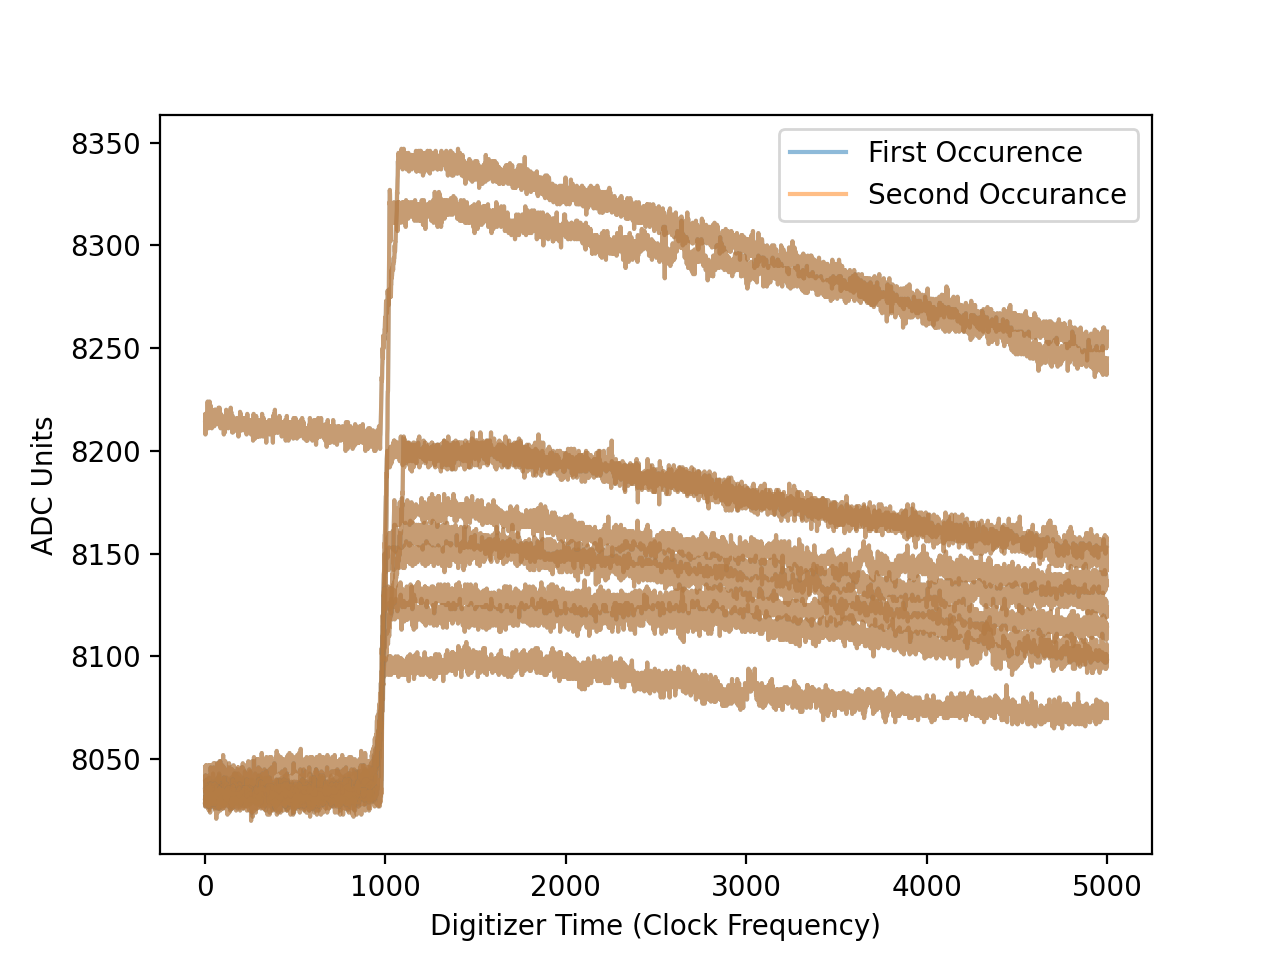

In [9]:
plt.figure()
plt.plot(1000,8150,c='tab:blue',label='First Occurence',alpha=0.5)
plt.plot(1000,8150,c='tab:orange',label='Second Occurance',alpha=0.5)
for i in range(10):
    n = int(np.random.rand()*len(pulses1))
    plt.plot(pulses1[n],c='tab:blue',alpha=0.5)
    plt.plot(pulses2[n],c='tab:orange',alpha=0.5)
plt.legend()
plt.xlabel('Digitizer Time (Clock Frequency)')
plt.ylabel('ADC Units')
plt.show()
plt.savefig('figs/repeated_pulses_waveforms.png')

# inspect raw pulses

<IPython.core.display.Javascript object>


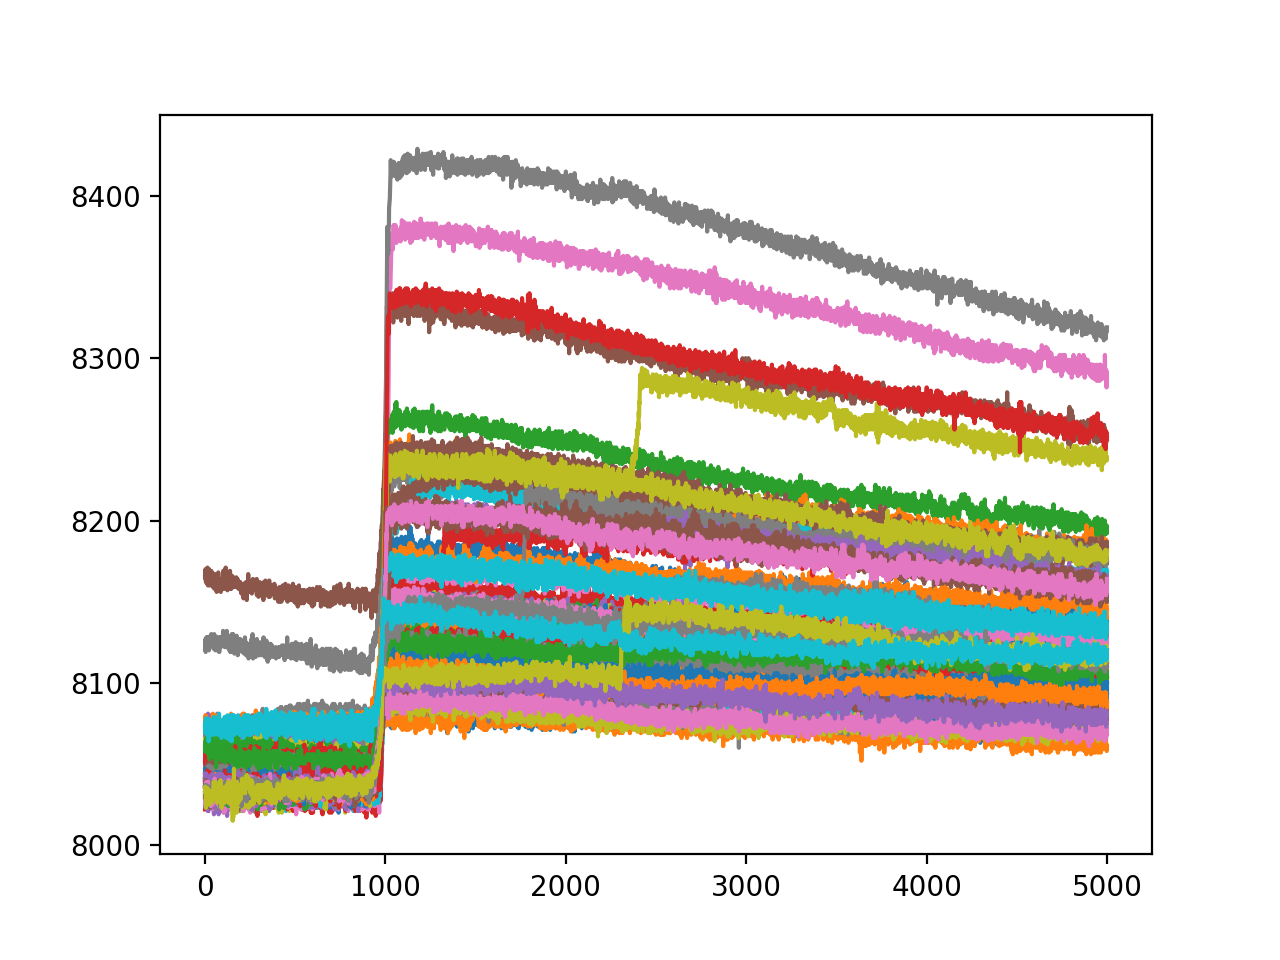

In [10]:
# plot random pulses
# number of random pulses
number_of_pulses = 100
plt.figure()
for i in range(number_of_pulses):
    n = int(np.random.rand()*len(calibration_cleaned))
    plt.plot(calibration_cleaned[n])
#plt.xlim(920,1150)
plt.show()

# Filter pulses

<IPython.core.display.Javascript object>


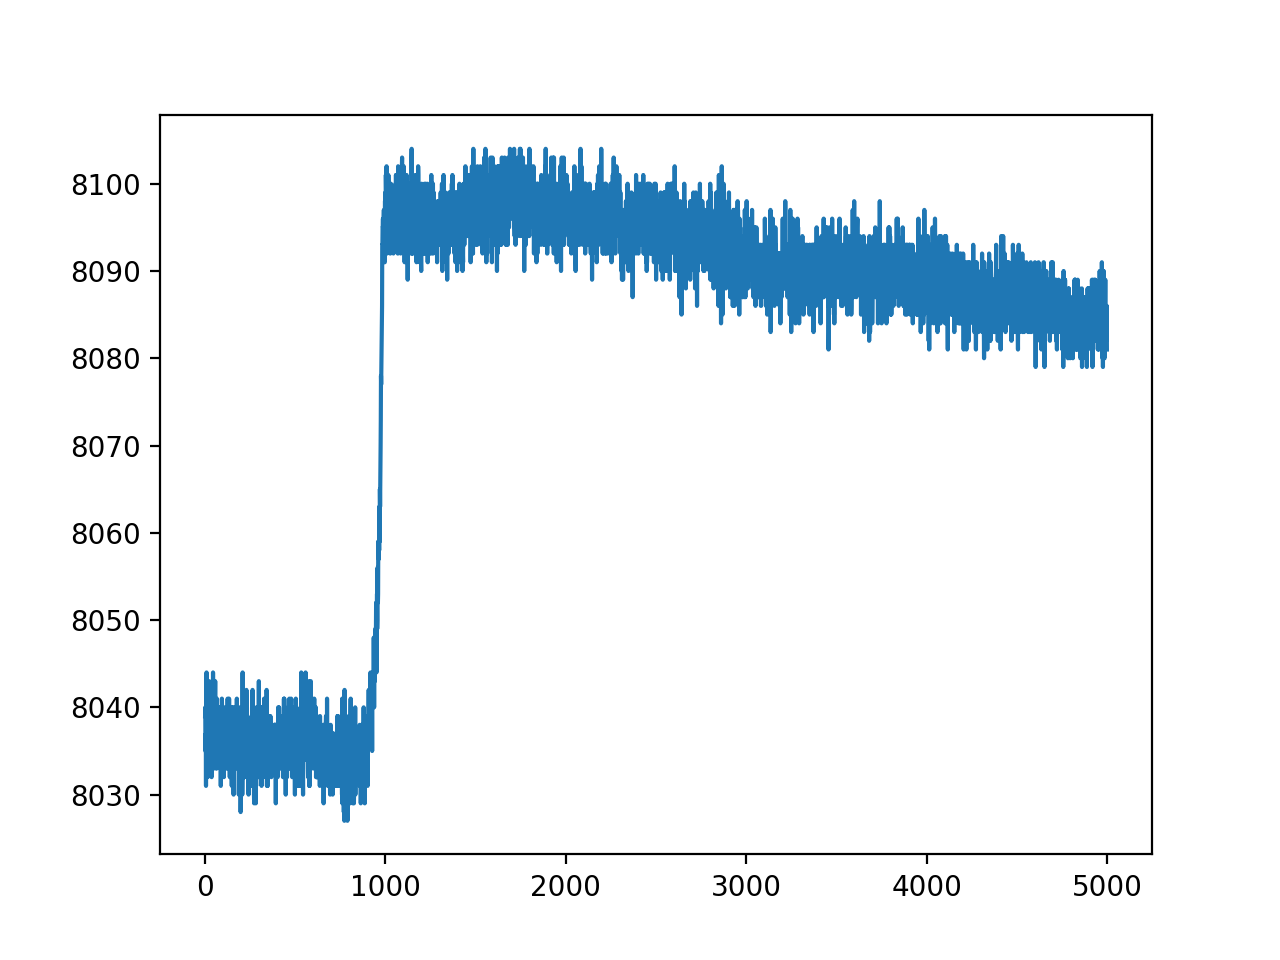

In [22]:
plt.figure()
plt.plot(calibration_cleaned[5])
plt.show()

In [23]:
pre_sample_length = 1000
average_background = np.int16(np.mean(calibration_cleaned[:,0:pre_sample_length-100]))
pulse_data = calibration_cleaned - average_background

In [17]:
pulse_data[:,900:]

array([[65527, 65529, 65526, ...,   120,   118,   115],
       [65530, 65533, 65533, ...,    65,    65,    64],
       [65531, 65528, 65532, ...,    53,    53,    55],
       ...,
       [    1, 65535,     6, ...,    64,    64,    65],
       [  113,   115,   108, ...,   142,   142,   135],
       [65528, 65526, 65527, ...,    69,    73,    71]], dtype=uint16)

In [15]:
average_background

8043

<IPython.core.display.Javascript object>


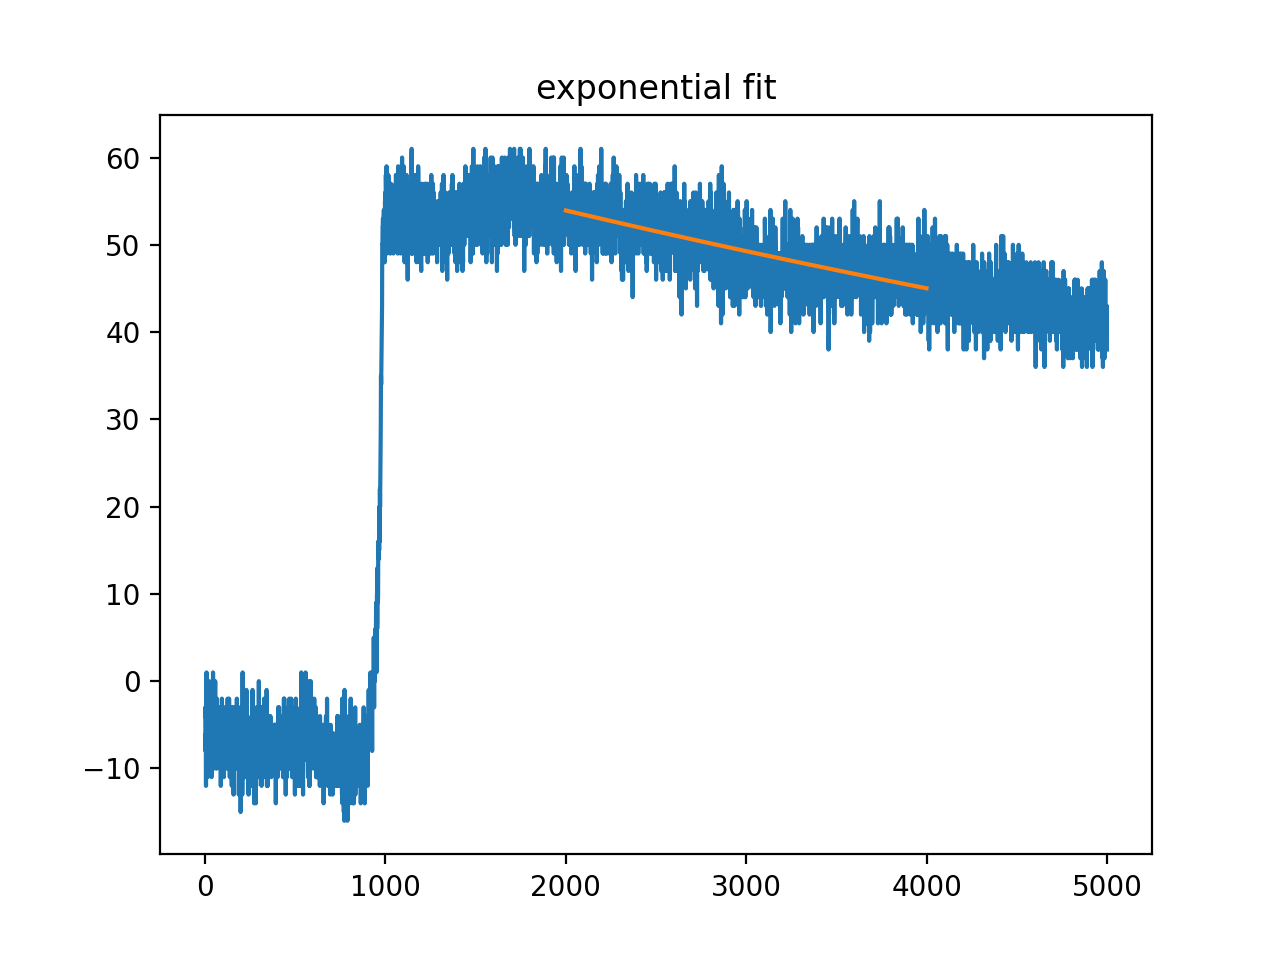

9.035821249584738e-05


In [24]:
#plt.figure()
tau = fit_tau(pulse_data[5],2000,fit_length=2000,show_plot=True)

sampling_interval=4e-9
plt.title('exponential fit')
print(1/tau)
plt.show()

In [25]:
tau

11067.062665122523

In [13]:
calibration_cleaned.shape

(913017, 5000)

<IPython.core.display.Javascript object>


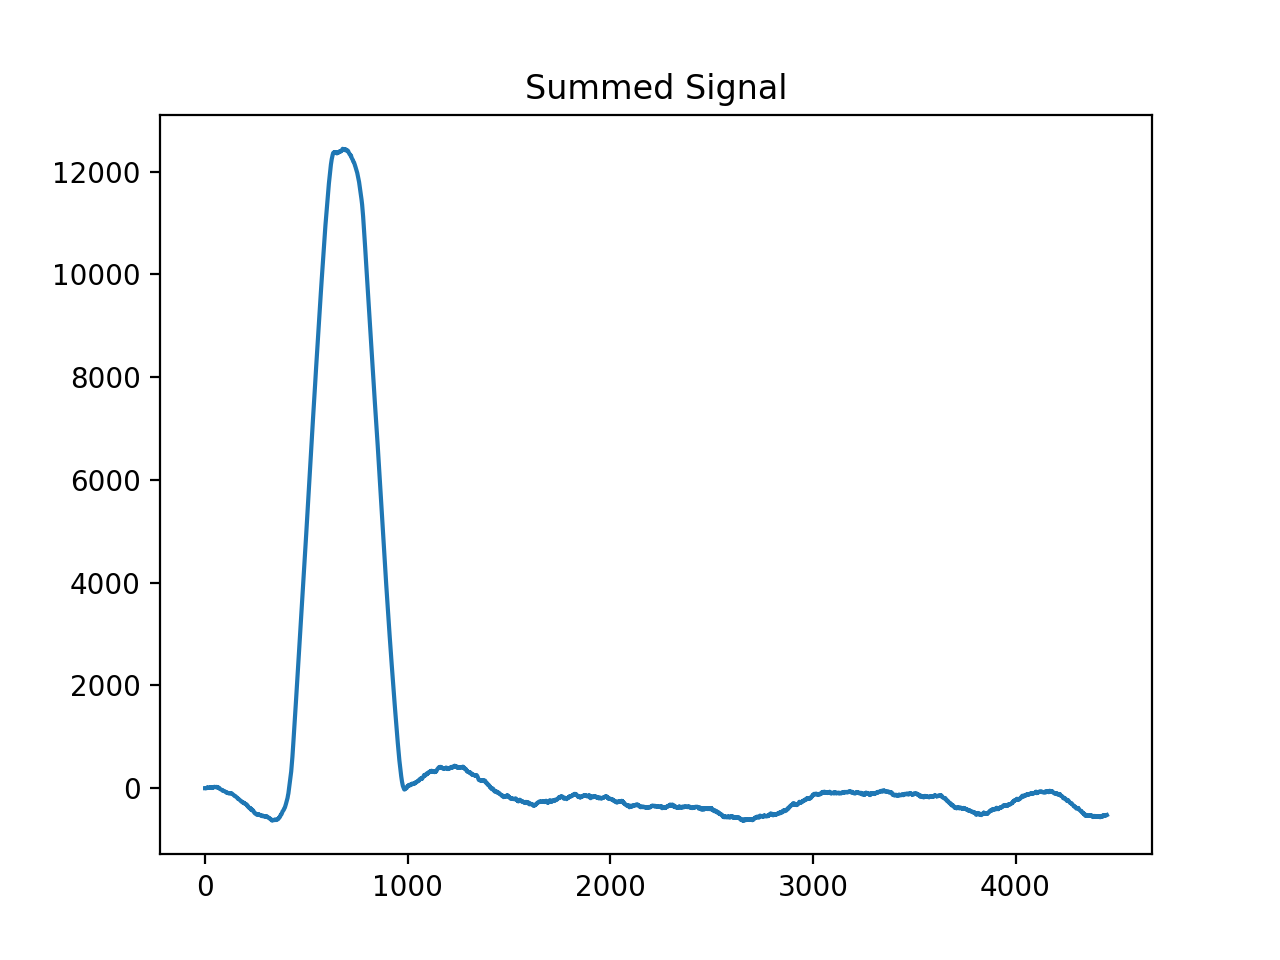

Run time: 0.0007169246673583984


In [26]:
plt.figure()
peaking_time = 0.8e-6
gap_time = 0.6e-6
#tau = 15000

t1 = time.time()
summed_signal, filtered_signal, max_val = trapezoidal_filter(peaking_time, gap_time, tau, pulse_data[5])
t2 = time.time()
print("Run time: {0}".format(t2-t1))

plt.plot(summed_signal)
plt.title('Summed Signal')
#plt.xlim(0,2000)
plt.show()

<IPython.core.display.Javascript object>


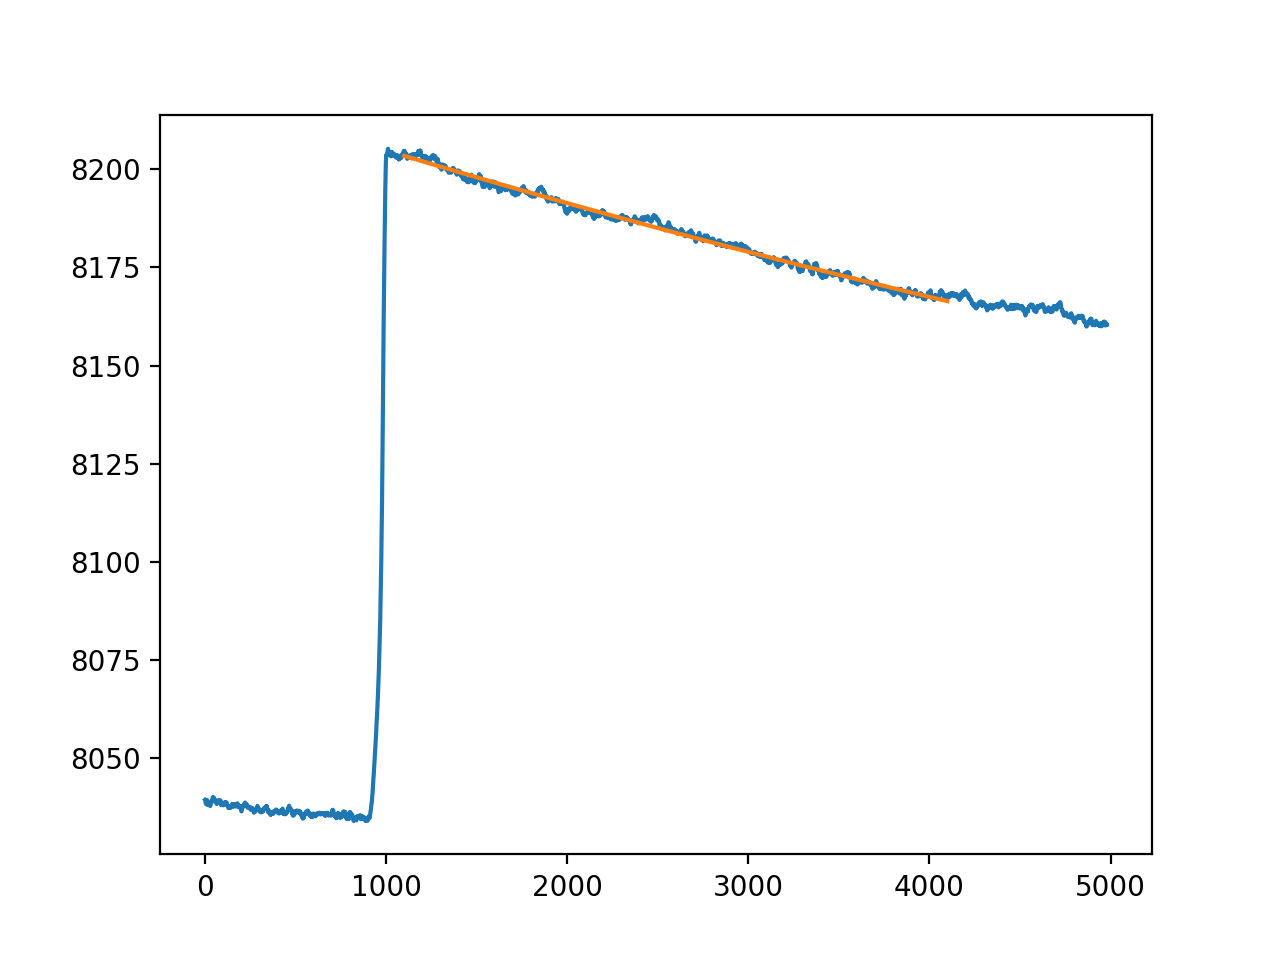

21026.661119822373


<IPython.core.display.Javascript object>


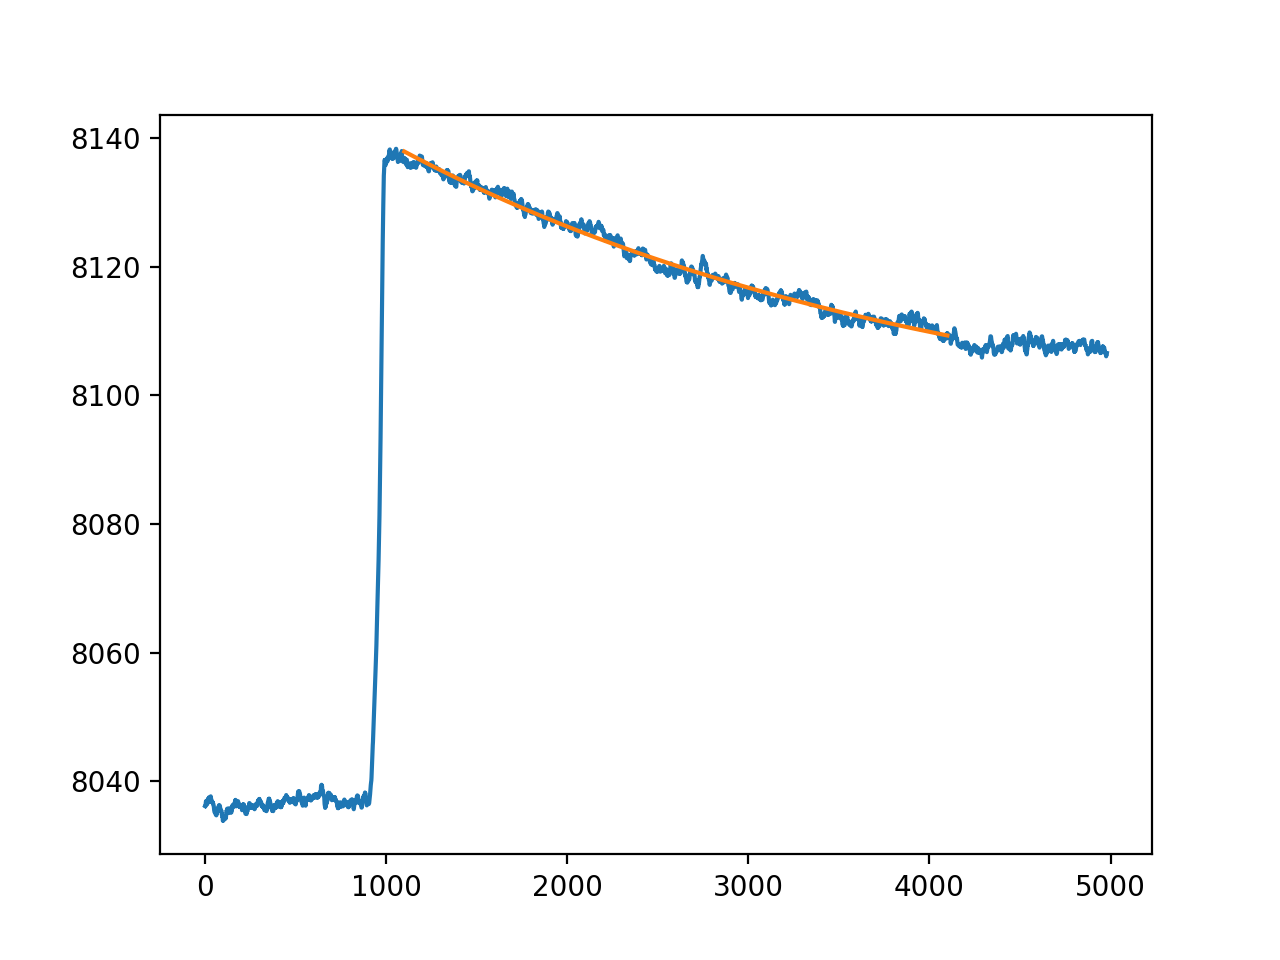

5084.540252045894


<IPython.core.display.Javascript object>


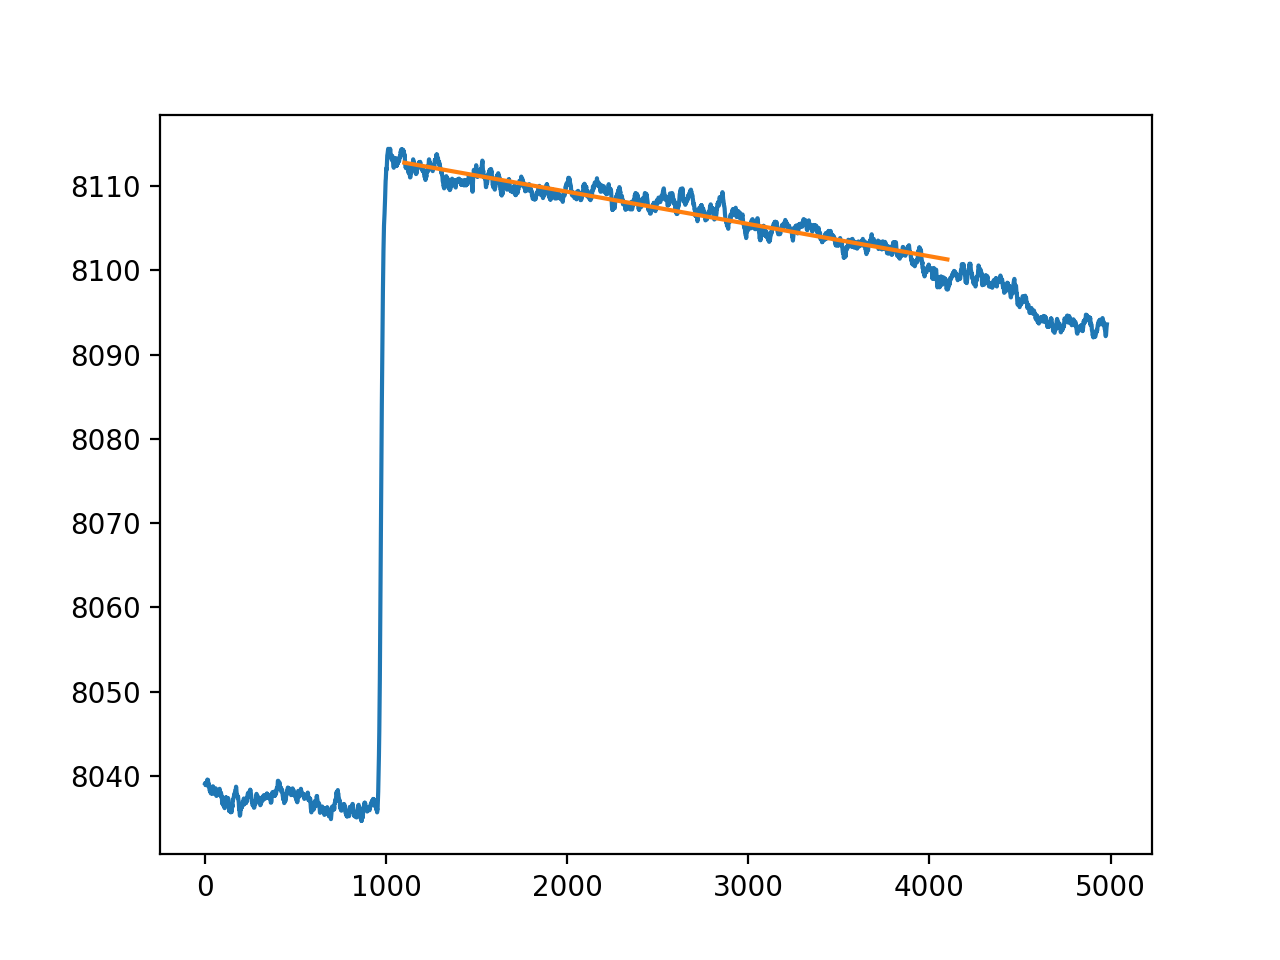

125292414.55362676
Fitted Decay Constant Tau: 41772841.918332875


In [15]:
tau = 0
num_to_fit_tau = 3
# Average tau over first 20 pulses
for i in range(num_to_fit_tau):
    tau_val = fit_tau(pulse_data[i],1100,fit_length=3000,show_plot=True)
    print(tau_val)
    tau += tau_val
tau = tau/num_to_fit_tau
print("Fitted Decay Constant Tau: {0}".format(tau))

In [ ]:
tau = 0
num_to_fit_tau = 1000
tau_values = []
for i in range(num_to_fit_tau):
    tau_val = fit_tau(pulse_data[i],1400,fit_length=2000,show_plot=False)
    if tau_val < 1e6:
        tau_values += [tau_val]
tau_values = np.array(tau_values)
tau_mean = np.mean(tau_values)
tau_std = np.std(tau_values)
non_outliers = tau_values[ np.where( np.abs(tau_values - tau_mean) < 3*tau_std) ]
tau = np.mean( non_outliers )
print("Fitted Decay Constant Tau: {0}".format(np.round(tau,2)))

In [27]:
trapezoidal_filter?

In [55]:
trapezoidal_filter??

<IPython.core.display.Javascript object>


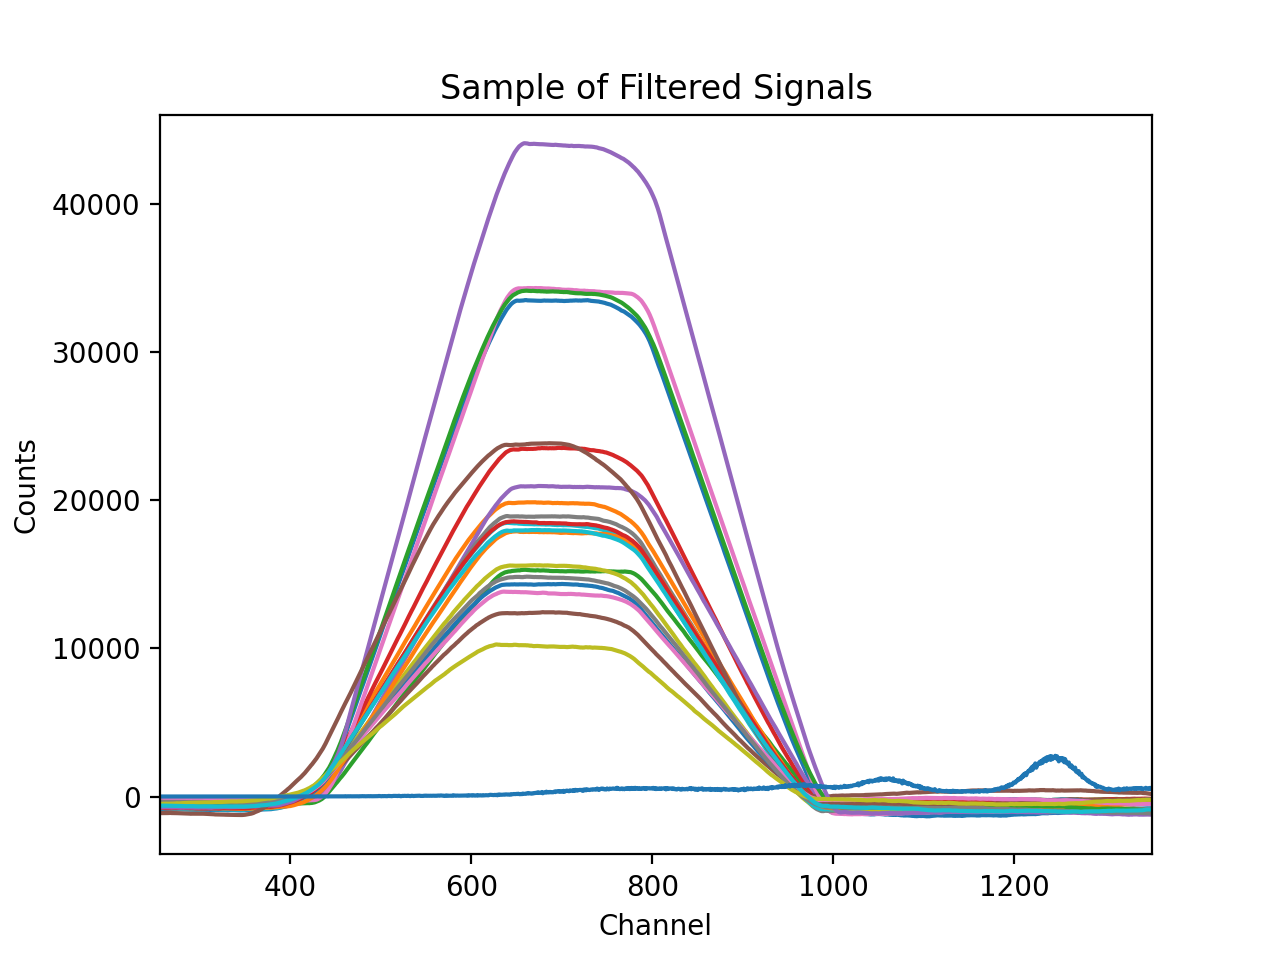

[33509.046      19865.80581818 15304.39118182 ... 17687.60781818
 17593.59927273 18633.69381818]


In [28]:
num_pulses = len(pulse_data)
trapezoid_heights = np.zeros(num_pulses)

plt.figure()
for i in range(num_pulses):
    signal, trap_filt, trapezoid_heights[i] = trapezoidal_filter(peaking_time, gap_time, 11000,pulse_data[i])
    if i < 20:
        plt.plot(signal)
        plt.plot()
    if i == 21:
        plt.title("Sample of Filtered Signals")
        plt.show()
print(trapezoid_heights)

In [38]:
make_histogram??

In [39]:
np.quantile?

In [53]:
trapezoid_heights

array([33509.046     , 19865.80581818, 15304.39118182, ...,
       17687.60781818, 17593.59927273, 18633.69381818])

<IPython.core.display.Javascript object>


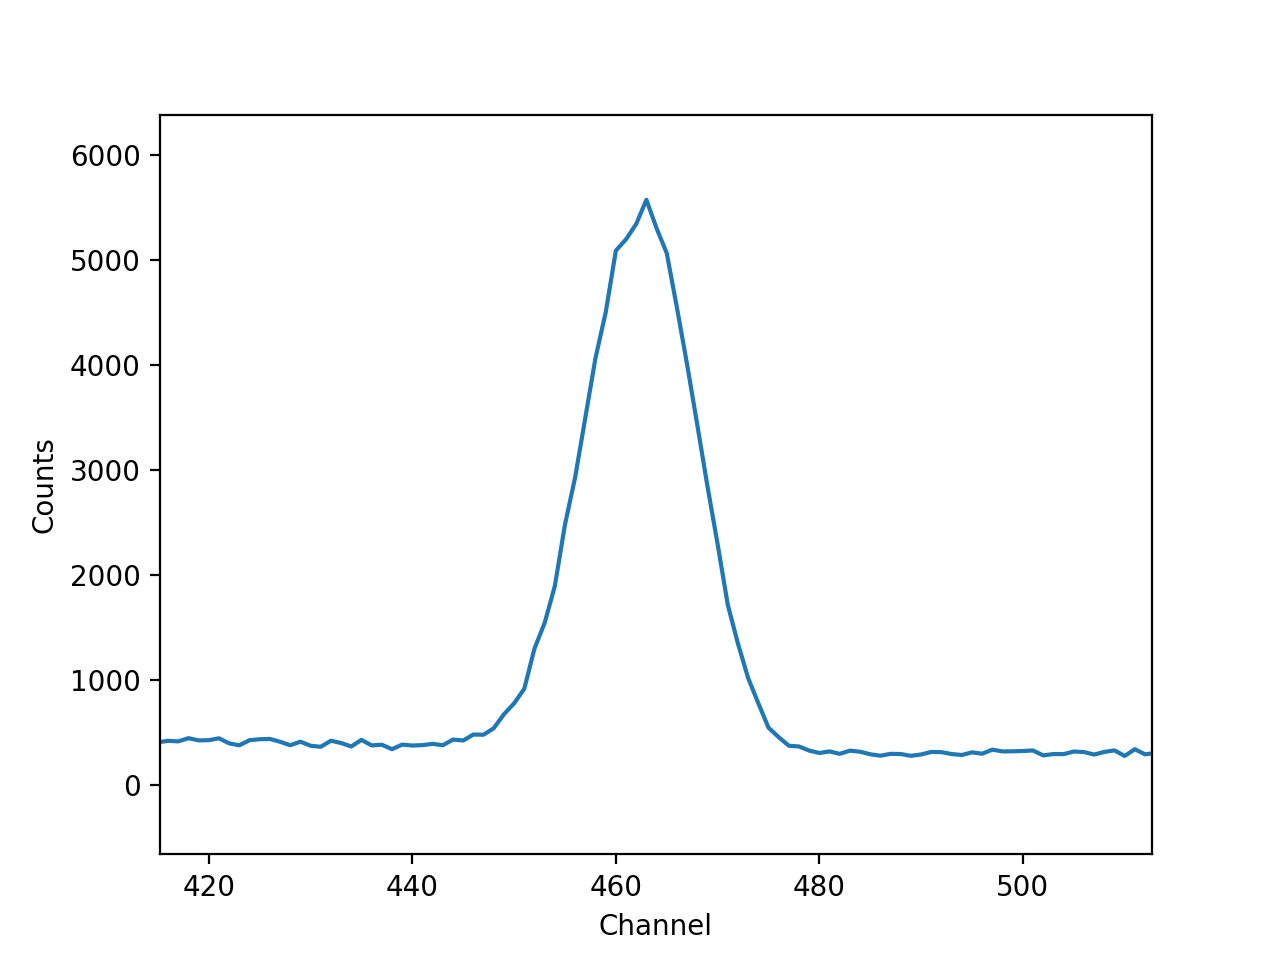

In [51]:
plt.figure()
counts = make_histogram(trapezoid_heights, 1000, do_plot = True, upper_noise_cutoff=0.998)
plt.show()

In [47]:
source_energies = [276.398, 302.853, 356.0129, 383.851, 661.7, 1173.228, 1332.492]
#source_energies = [1173.228, 1332.492]

binned_spectrum = Spectrum(counts)

binned_spectrum.calibrate( source_energies, auto_calibrate=True , reset_calibration = True , auto_prominence=1000, show_fit = True)



KeyboardInterrupt: 

<IPython.core.display.Javascript object>


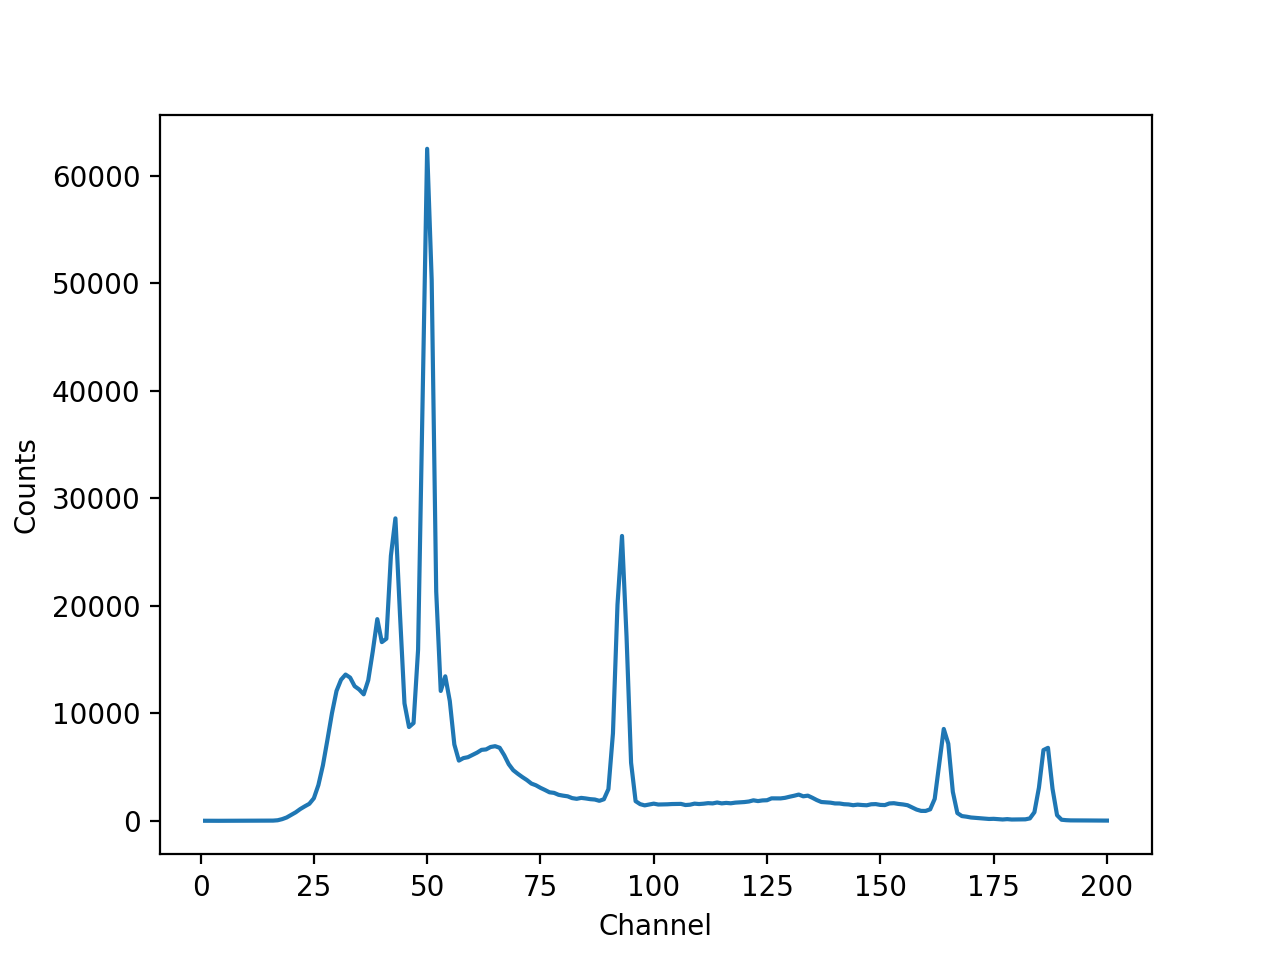

In [45]:
plt.figure()
binned_spectrum.show_histogram('Spectrum')
plt.show()

In [30]:
gap_vals = np.linspace(0.5e-7, 1.1e-6, 7)
peaking_vals = np.linspace(0.5e-7, 2.5e-6, 7)
pre_trigger_delay = 1000
num_pulses = len(pulse_data)
FWHM_matrix = np.zeros( (len(gap_vals), len(peaking_vals)) )


for gap_i in range(len(gap_vals)):
    for peak_i in range(len(peaking_vals)):
        gap_time = gap_vals[gap_i]
        peak_time = peaking_vals[peak_i]
        print("gap time = {0}mcs, peak time = {1}mcs".format(round(gap_time*1e6,1), round(peak_time*1e6,1)))
        trapezoid_heights = np.zeros(num_pulses)
        for i in range(num_pulses):
            signal, trap_filter, trapezoid_height  = trapezoidal_filter(peak_time,gap_time,11000,pulse_data[i])
            trapezoid_heights[i] = trapezoid_height
        counts = make_histogram(trapezoid_heights, 4000, do_plot = True, upper_noise_cutoff=0.998)
        binned_spectrum = Spectrum(counts)
        source_energies = [661.7, 1173.228, 1332.492]
        binned_spectrum.calibrate( source_energies, auto_calibrate=True , reset_calibration = True , auto_prominence=600)
        energy, FWHM_vals = binned_spectrum.calc_FWHMs()
        avg_FWHM = np.sum(FWHM_vals)/3
        print(avg_FWHM)
        FWHM_matrix[gap_i, peak_i] = avg_FWHM
        print("\n\n")

gap time = 0.0mcs, peak time = 0.0mcs
[621 count peak at 1265 between 1264 and 1265, 694 count peak at 1288 between 1287 and 1288, 810 count peak at 1310 between 1309 and 1310, 877 count peak at 1333 between 1332 and 1333, 931 count peak at 1355 between 1354 and 1355, 1079 count peak at 1378 between 1377 and 1378, 1179 count peak at 1401 between 1400 and 1401, 1334 count peak at 1423 between 1422 and 1423, 1489 count peak at 1446 between 1445 and 1446, 1611 count peak at 1468 between 1467 and 1468, 1828 count peak at 1491 between 1490 and 1491, 1885 count peak at 1514 between 1513 and 1514, 2118 count peak at 1536 between 1535 and 1536, 2360 count peak at 1559 between 1558 and 1559, 2575 count peak at 1581 between 1580 and 1581, 2806 count peak at 1604 between 1603 and 1604, 3114 count peak at 1627 between 1626 and 1627, 3358 count peak at 1649 between 1648 and 1649, 3584 count peak at 1672 between 1671 and 1672, 3963 count peak at 1694 between 1693 and 1694, 4112 count peak at 1717 be

[753 count peak at 1370 between 1369 and 1370, 822 count peak at 1399 between 1398 and 1399, 977 count peak at 1427 between 1426 and 1427, 1127 count peak at 1465 between 1464 and 1465, 1298 count peak at 1493 between 1492 and 1493, 1484 count peak at 1522 between 1521 and 1522, 1733 count peak at 1550 between 1549 and 1550, 2020 count peak at 1588 between 1587 and 1588, 2262 count peak at 1616 between 1615 and 1616, 2640 count peak at 1654 between 1653 and 1654, 2997 count peak at 1692 between 1691 and 1692, 3259 count peak at 1720 between 1719 and 1720, 3672 count peak at 1749 between 1748 and 1749, 4204 count peak at 1796 between 1795 and 1796, 4633 count peak at 1834 between 1833 and 1834, 4955 count peak at 1862 between 1861 and 1862, 5441 count peak at 1900 between 1899 and 1900, 5779 count peak at 1928 between 1927 and 1928, 6034 count peak at 1957 between 1956 and 1957, 6446 count peak at 1985 between 1984 and 1985, 6840 count peak at 2023 between 2022 and 2023, 7036 count peak

[668 count peak at 2414 between 2413 and 2414, 737 count peak at 2442 between 2441 and 2442, 867 count peak at 2470 between 2469 and 2470, 923 count peak at 2495 between 2494 and 2495, 1017 count peak at 2520 between 2519 and 2520, 1211 count peak at 2540 between 2539 and 2540, 1217 count peak at 2562 between 2561 and 2562, 1353 count peak at 2593 between 2592 and 2593, 1545 count peak at 2615 between 2614 and 2615, 1628 count peak at 2638 between 2637 and 2638, 1714 count peak at 2660 between 2659 and 2660, 1846 count peak at 2691 between 2690 and 2691, 2016 count peak at 2716 between 2715 and 2716, 2216 count peak at 2744 between 2743 and 2744, 2334 count peak at 2780 between 2779 and 2780, 2515 count peak at 2808 between 2807 and 2808, 2522 count peak at 2828 between 2827 and 2828, 2655 count peak at 2850 between 2849 and 2850, 2752 count peak at 2870 between 2869 and 2870, 2742 count peak at 2892 between 2891 and 2892, 2852 count peak at 2912 between 2911 and 2912, 2897 count peak 

[665 count peak at 1175 between 1174 and 1175, 790 count peak at 1204 between 1203 and 1204, 950 count peak at 1233 between 1232 and 1233, 1218 count peak at 1276 between 1275 and 1276, 1317 count peak at 1305 between 1304 and 1305, 1653 count peak at 1348 between 1347 and 1348, 1916 count peak at 1377 between 1376 and 1377, 2240 count peak at 1406 between 1405 and 1406, 2406 count peak at 1435 between 1434 and 1435, 2685 count peak at 1464 between 1463 and 1464, 3014 count peak at 1492 between 1491 and 1492, 3309 count peak at 1521 between 1520 and 1521, 3804 count peak at 1550 between 1549 and 1550, 4494 count peak at 1593 between 1592 and 1593, 4638 count peak at 1622 between 1621 and 1622, 5287 count peak at 1665 between 1664 and 1665, 5741 count peak at 1694 between 1693 and 1694, 6409 count peak at 1737 between 1736 and 1737, 6906 count peak at 1766 between 1765 and 1766, 7654 count peak at 1809 between 1808 and 1809, 7916 count peak at 1838 between 1837 and 1838, 8474 count peak

[613 count peak at 2382 between 2381 and 2382, 730 count peak at 2406 between 2405 and 2406, 811 count peak at 2426 between 2425 and 2426, 919 count peak at 2453 between 2452 and 2453, 1075 count peak at 2480 between 2479 and 2480, 1196 count peak at 2500 between 2499 and 2500, 1334 count peak at 2527 between 2526 and 2527, 1475 count peak at 2547 between 2546 and 2547, 1548 count peak at 2571 between 2570 and 2571, 1713 count peak at 2591 between 2590 and 2591, 1862 count peak at 2615 between 2614 and 2615, 1989 count peak at 2635 between 2634 and 2635, 2149 count peak at 2655 between 2654 and 2655, 2202 count peak at 2675 between 2674 and 2675, 2448 count peak at 2699 between 2698 and 2699, 2577 count peak at 2726 between 2725 and 2726, 2820 count peak at 2746 between 2745 and 2746, 2863 count peak at 2770 between 2769 and 2770, 2993 count peak at 2790 between 2789 and 2790, 3116 count peak at 2810 between 2809 and 2810, 3270 count peak at 2834 between 2833 and 2834, 3388 count peak 

[636 count peak at 1272 between 1271 and 1272, 758 count peak at 1300 between 1299 and 1300, 872 count peak at 1328 between 1327 and 1328, 964 count peak at 1355 between 1354 and 1355, 1205 count peak at 1383 between 1382 and 1383, 1350 count peak at 1411 between 1410 and 1411, 1608 count peak at 1452 between 1451 and 1452, 1857 count peak at 1480 between 1479 and 1480, 2112 count peak at 1508 between 1507 and 1508, 2423 count peak at 1535 between 1534 and 1535, 2704 count peak at 1563 between 1562 and 1563, 3037 count peak at 1591 between 1590 and 1591, 3429 count peak at 1632 between 1631 and 1632, 3995 count peak at 1660 between 1659 and 1660, 4172 count peak at 1688 between 1687 and 1688, 4544 count peak at 1715 between 1714 and 1715, 4997 count peak at 1743 between 1742 and 1743, 5535 count peak at 1771 between 1770 and 1771, 5842 count peak at 1798 between 1797 and 1798, 6335 count peak at 1826 between 1825 and 1826, 6702 count peak at 1854 between 1853 and 1854, 7371 count peak 

KeyboardInterrupt: 

In [ ]:
plt.figure()
im = plt.imshow(FWHM_matrix,cmap='RdYlGn_r', vmin=5,vmax=15, extent=[min(gap_vals)*1e6,max(gap_vals)*1e6,min(peaking_vals)*1e6,max(peaking_vals)*1e6]) 
plt.xlabel("Gap Time (mcs)")
plt.ylabel("Peaking Time (mcs)")
plt.colorbar()
plt.show()
print(np.min(np.abs(FWHM_matrix)))
print(np.where(FWHM_matrix == np.min(np.abs(FWHM_matrix))))
print(gap_vals[0])
print(peaking_vals[1])
gap_time = 0.1e-6
peak_time = 0.5e-6

In [ ]:
def noises(t,A,B,C):
    return A*t + B/t + C